# Определение возраста покупателей

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

   - Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
   - Контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.

**Шаги выполнения проекта:**

  1.  Провести исследовательский анализ набора фотографий.
  2.  Подготовить данные к обучению.
  3.  Обучить нейронную сеть.
  4.  Рассчитать качество модели.

# 1. Исследовательский анализ данных

In [1]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
labels = pd.read_csv('***')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='***',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [3]:
features, target = next(train_gen_flow)
features.shape

(32, 224, 224, 3)

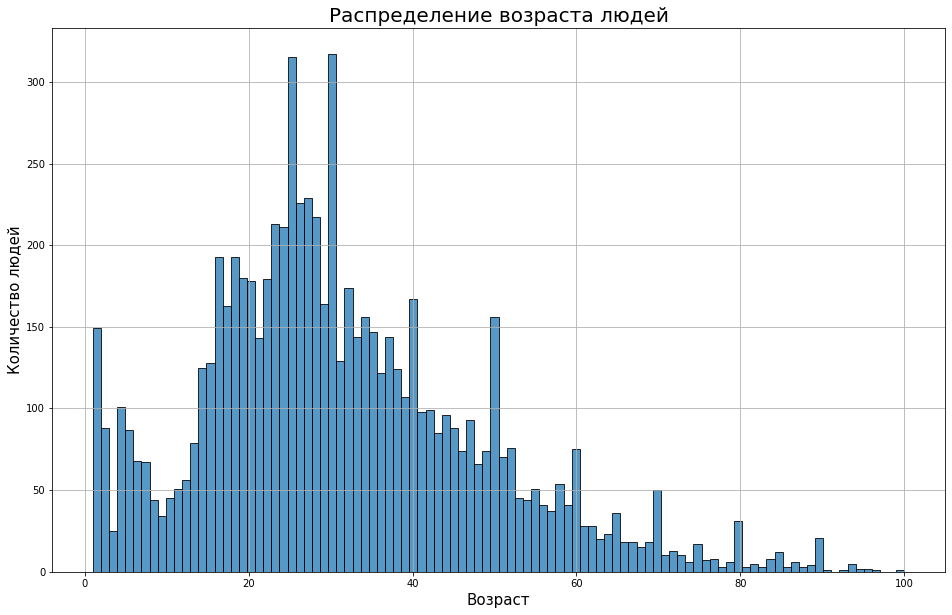

In [4]:
plt.figure(figsize=(16,10))
sns.histplot(data=labels['real_age'], bins=100)
plt.title('Распределение возраста людей', fontsize=20);
plt.ylabel('Количество людей',fontsize = 15)
plt.xlabel('Возраст',fontsize = 15)
plt.grid()

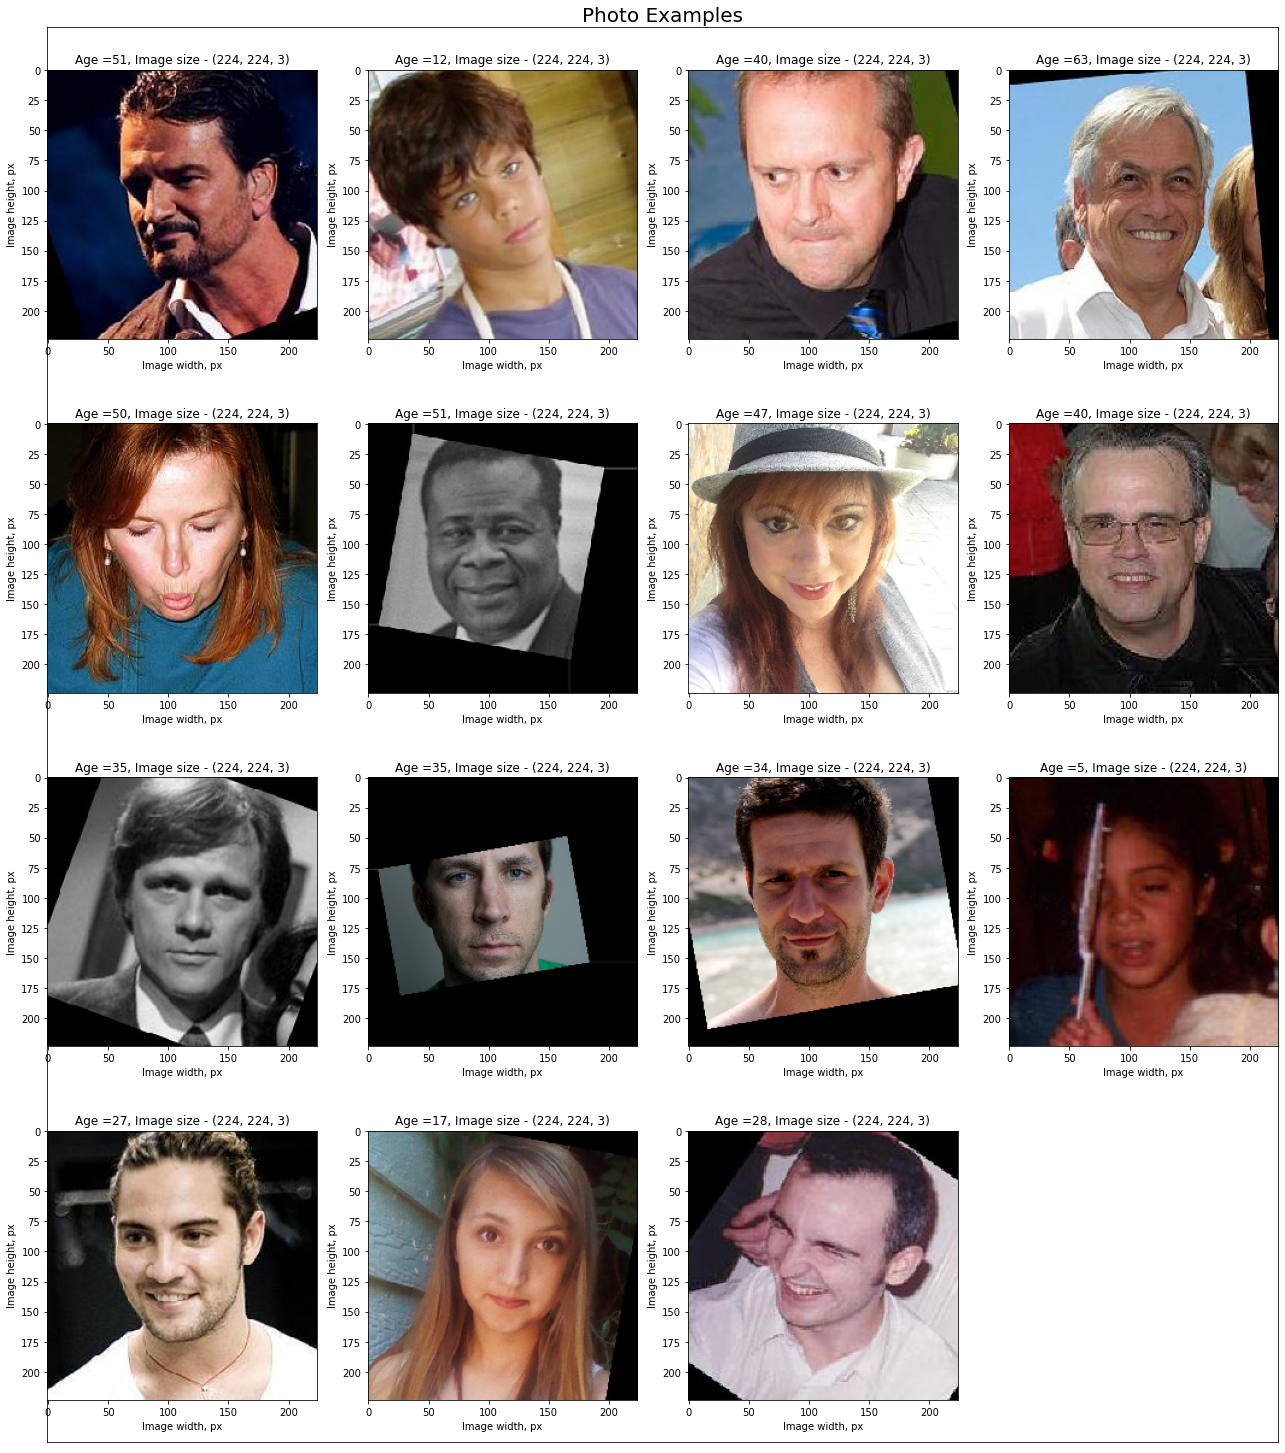

In [5]:
features, target = next(train_gen_flow)

# выводим 15 изображений

fig = plt.figure(figsize=(18,20))
plt.title('Photo Examples', {'fontsize': 20,
 'fontweight' : 10,
 'verticalalignment': 'baseline'})
plt.xticks([])
plt.yticks([])
plt.tight_layout()
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.tight_layout() 
    plt.title('Age ={}, Image size - {}'.format(target[i], features[i].shape), loc='center')    
    plt.xlabel('Image width, px')
    plt.ylabel('Image height, px')

График распределения напоминает распределение Пуассона. График смещен вправо, среднее больше медианы. Имеется довольно много фотографий детей 1-2 лет.

Заметны пики по "круглым датам". 30, 40, 50 и т.д. Возможно это связано с тем, что настоящий возраст был неизвестен тому, кто размечал датасет, и он его попросту округлял. Поэтому, некоторые "круглые" года в датасете некорректные.

In [6]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


**Вывод**

- В выборке 7591 фотография. Относительно небольшая подборка для оценки возраста.
- Общая ориентация фотографий примерно одинакова - в некоторых фото их уже повернули за нас, чтобы выровнять положение лица, нам не обязательно их поворачивать.
- Замечены очки, посторонние предметы, закрывающие лицо, обрезанные части лица. Это может ухудшить обучение.
- Размер изображений отличается, в силу того, что визуально заметно различное качество фото, где-то есть черные рамки (они не несут полезной информации). В итоге, размер изображений мы приведем к единому перед обучением модели.
- Большинство людей от 18 до 40 лет.

# 2. Обучение модели

**Код модели:**

```python

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen_train = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_gen_flow = datagen_train.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen_test = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen_test.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow


def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mean_absolute_error',
                  metrics=['mean_absolute_error'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```

Found 5694 validated image filenames.

Found 1897 validated image filenames.

Train for 356 steps, validate for 119 steps

Epoch 1/10


356/356 - 68s - loss: 10.7652 - mean_absolute_error: 10.7648 - val_loss: 24.0324 - val_mean_absolute_error: 24.0321

Epoch 2/10

356/356 - 38s - loss: 7.5212 - mean_absolute_error: 7.5215 - val_loss: 11.7257 - val_mean_absolute_error: 11.7278

Epoch 3/10

356/356 - 38s - loss: 6.5231 - mean_absolute_error: 6.5232 - val_loss: 7.1979 - val_mean_absolute_error: 7.1959

Epoch 4/10

356/356 - 38s - loss: 5.8712 - mean_absolute_error: 5.8715 - val_loss: 6.8668 - val_mean_absolute_error: 6.8691

Epoch 5/10

356/356 - 38s - loss: 5.4627 - mean_absolute_error: 5.4637 - val_loss: 6.9992 - val_mean_absolute_error: 7.0016

Epoch 6/10

356/356 - 38s - loss: 4.9752 - mean_absolute_error: 4.9753 - val_loss: 7.2623 - val_mean_absolute_error: 7.2619

Epoch 7/10

356/356 - 38s - loss: 4.5885 - mean_absolute_error: 4.5893 - val_loss: 6.8549 - val_mean_absolute_error: 6.8602

Epoch 8/10

356/356 - 38s - loss: 4.1940 - mean_absolute_error: 4.1943 - val_loss: 6.2565 - val_mean_absolute_error: 6.2632

Epoch 9/10

356/356 - 37s - loss: 3.9389 - mean_absolute_error: 3.9392 - val_loss: 8.0947 - val_mean_absolute_error: 8.0931

Epoch 10/10

356/356 - 38s - loss: 3.7537 - mean_absolute_error: 3.7539 - val_loss: 6.1399 - val_mean_absolute_error: 6.1431



119/119 - 9s - loss: 6.1399 - mean_absolute_error: 6.1431

Test MAE: 6.1431

```

# 3. Анализ обученной модели

- Удалось достичь МАЕ = 6,14 за 10 эпох. Это значит, что наша модель ошибается в определении возраста в среднем на 6 лет.
- Была применена архитектура ResNet50, предобученная на датасете ImageNet, чтобы улучшить результат.
- Я использовал "заморозку сети". Это позволило избавиться от переобучения и повысить скорость обучения сети.
- Применен оптимизатор Adam с шагом обучения 0,0001, для повышения точности модели.
- Модель справилась довольно успешно. В изначальном исследовании, от куда был взят датасет, МАЕ = 5,4.
- С данной моделью магазину будет легче отслеживать возраст покупателей для анализа покупок и рекламы товаров для определенной возрастной группы.